# Project bakcground
### This is a Kaggle open challenge back in 2020

Most flight-related fatalities stem from a loss of “airplane state awareness.” That is, ineffective attention management on the part of pilots who may be distracted, sleepy or in other dangerous cognitive states.

This challenge is to build a model to detect troubling events from aircrew’s physiological data. The data was acquired from actual pilots in test situations, and the models should be able to run calculations in real time to monitor the cognitive states of pilots. Using the model prediction, pilots could then be alerted when they enter a troubling state, preventing accidents and saving lives.


### Data dessciption

The dataset is real physiological data from eighteen pilots who were subjected to various distracting events. The benchmark training set is comprised of a set of controlled experiments collected in a non-flight environment, outside of a flight simulator. The test set (abbreviated LOFT = Line Oriented Flight Training) consists of a full flight (take off, flight, and landing) in a flight simulator.

The pilots experienced distractions intended to induce one of the following three cognitive states:

Channelized Attention (CA) is, roughly speaking, the state of being focused on one task to the exclusion of all others. This is induced in benchmarking by having the subjects play an engaging puzzle-based video game.
Diverted Attention (DA) is the state of having one’s attention diverted by actions or thought processes associated with a decision. This is induced by having the subjects perform a display monitoring task. Periodically, a math problem showed up which had to be solved before returning to the monitoring task.
Startle/Surprise (SS) is induced by having the subjects watch movie clips with jump scares.
For each experiment, a pair of pilots (each with its own crew id) was recorded over time and subjected to the CA, DA, or SS cognitive states. The training set contains three experiments (one for each state) in which the pilots experienced just one of the states. For example, in the experiment = CA, the pilots were either in a baseline state (no event) or the CA state. The test set contains a full flight simulation during which the pilots could experience any of the states (but never more than one at a time). The goal of this competition is to predict the probability of each state for each time in the test set.

Each sensor operated at a sample rate of 256 Hz. Please note that since this is physiological data from real people, there will be noise and artifacts in the data.

In [1]:
import warnings
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss

warnings.simplefilter(action='ignore')
sns.set_style('whitegrid')

## 1 - Loading the Data

In [2]:
dtypes = {"crew": "int8",
          "experiment": "category",
          "time": "float32",
          "seat": "int8",
          "eeg_fp1": "float32",
          "eeg_f7": "float32",
          "eeg_f8": "float32",
          "eeg_t4": "float32",
          "eeg_t6": "float32",
          "eeg_t5": "float32",
          "eeg_t3": "float32",
          "eeg_fp2": "float32",
          "eeg_o1": "float32",
          "eeg_p3": "float32",
          "eeg_pz": "float32",
          "eeg_f3": "float32",
          "eeg_fz": "float32",
          "eeg_f4": "float32",
          "eeg_c4": "float32",
          "eeg_p4": "float32",
          "eeg_poz": "float32",
          "eeg_c3": "float32",
          "eeg_cz": "float32",
          "eeg_o2": "float32",
          "ecg": "float32",
          "r": "float32",
          "gsr": "float32",
          "event": "category",
         }

In [3]:
train_df = pd.read_csv("../input/train.csv", dtype=dtypes)
test_df = pd.read_csv("../input/test.csv", dtype=dtypes)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 28 columns):
crew          int8
experiment    category
time          float32
seat          int8
eeg_fp1       float32
eeg_f7        float32
eeg_f8        float32
eeg_t4        float32
eeg_t6        float32
eeg_t5        float32
eeg_t3        float32
eeg_fp2       float32
eeg_o1        float32
eeg_p3        float32
eeg_pz        float32
eeg_f3        float32
eeg_fz        float32
eeg_f4        float32
eeg_c4        float32
eeg_p4        float32
eeg_poz       float32
eeg_c3        float32
eeg_cz        float32
eeg_o2        float32
ecg           float32
r             float32
gsr           float32
event         category
dtypes: category(2), float32(24), int8(2)
memory usage: 464.2 MB


No missing values.

In [5]:
train_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,23.712299,-6.695870,29.232100,24.842899,3.92134,18.447001,1.07547,3.09029,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,21.010300,-6.474720,26.641399,24.138800,5.46991,20.510599,2.83354,7.10177,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,25.431801,-0.088707,28.119900,26.891300,8.57886,23.162901,4.51993,12.70550,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,19.142799,-0.256516,30.653601,24.247000,8.64310,19.961901,7.27575,11.45980,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,20.572100,-1.953470,31.722601,25.155500,12.50030,18.746901,7.30976,8.00805,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [6]:
test_df.head()

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.899500,6.127830,0.994807,-28.206200,-47.695499,-187.080002,-33.183498,-4.220780,8.178160,33.160301,33.812500,21.744699,16.293800,-7.044480,-14.405100,-4.03384,-0.393799,31.83810,17.075600,-8.137350,-7323.120117,643.177002,594.778992
1,1,1,LOFT,0.000000,1,45.883202,94.749001,23.290800,1.392000,2.060940,-5.145290,6.395940,33.420101,-295.013000,8.373170,29.636400,16.223000,850.288025,19.887501,-215.179001,2.11832,7.340940,9.66785,1169.239990,-0.024414,-3335.080078,826.724976,136.235001
2,2,1,LOFT,0.003906,0,33.120098,28.356501,-7.239220,-7.690860,-25.833799,-107.236000,12.845200,1.215280,13.317000,44.435101,37.585800,29.073000,22.316099,-7.642560,-10.363600,10.95050,6.513360,36.01860,24.356600,0.956158,-7323.120117,643.177002,594.778992
3,3,1,LOFT,0.003906,1,43.280102,95.887001,18.702299,-1.432890,-4.232600,-8.021180,7.427430,27.345699,-310.165009,5.389070,27.733999,7.217500,816.679016,13.826600,-214.223007,-4.91354,3.504520,3.87811,1159.400024,-0.047607,-3335.080078,826.724976,136.235001
4,4,1,LOFT,0.007812,0,7.929110,3.460380,-10.860800,-26.366699,-25.894699,37.007900,-50.334202,-11.676400,-1.143860,-17.600500,34.075600,22.912399,19.033800,2.045450,-20.788799,-3.61418,-7.539830,3.08397,13.647900,1.473720,-7323.120117,643.177002,594.778992


## 2 - EDA

### Data Exploration

Each row is a set of samples from sensors in a specific timestamp, this row is unique for each pilot (a pilot is determined by the tuple (crew, seat) .<br>

There are 9 unique crews.<br>
In each crew there are two pilots, one on the left seat and one on the right seat.<br>

The same exact crews are in the test data.<br>

The train data is collected from experiments where the pilots were given tasks to complete while in different situations.<br>
The test data is collected while doing a flight simulation.<br>

Therefore we will not use the 'experiment', 'crew', and 'seat' features, as they will not be useful for the prediction.<br>

The sensors are: 
* **eeg** - Electroencephalogram - brain electrical activity sensors
* **ecg** - Electrocardiogram - heart electrical activity sensor, 
* **r** - Respiration - chest movement sensor 
* **gsr** - Galvanic Skin Response - skin reponse sensor.

Our target feature is 'event'. There are 4 events in this test with the labels which we need to learn and predict:
* **A** - baseline
* **B** - SS - Startle/Surprise
* **C** - CA - Channelized Attention
* **D** - DA - Diverted Attention

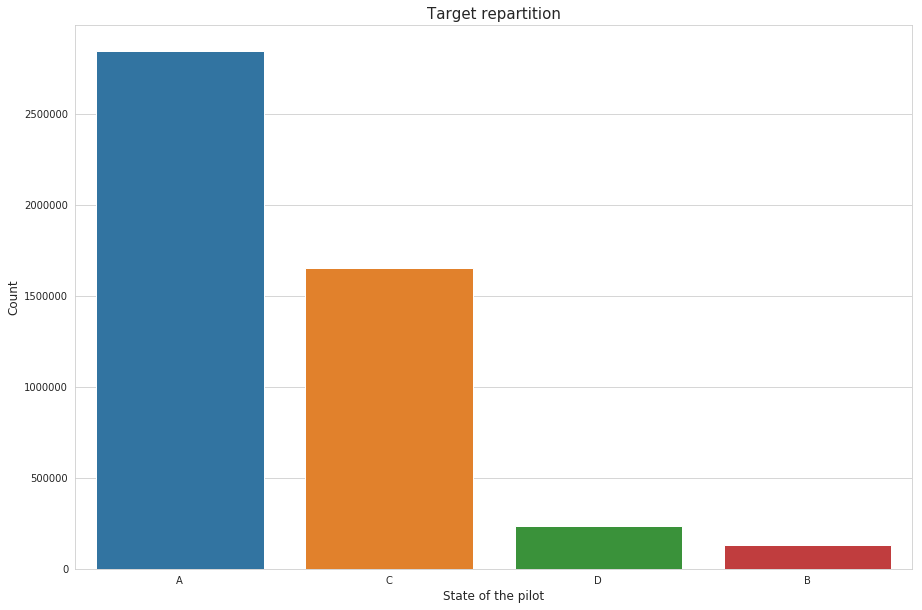

In [7]:
plt.figure(figsize=(15,10))
sns.countplot(train_df['event'])
plt.xlabel("State of the pilot", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Target repartition", fontsize=15)
plt.show()

We can expect issues with classes D and B being under represented

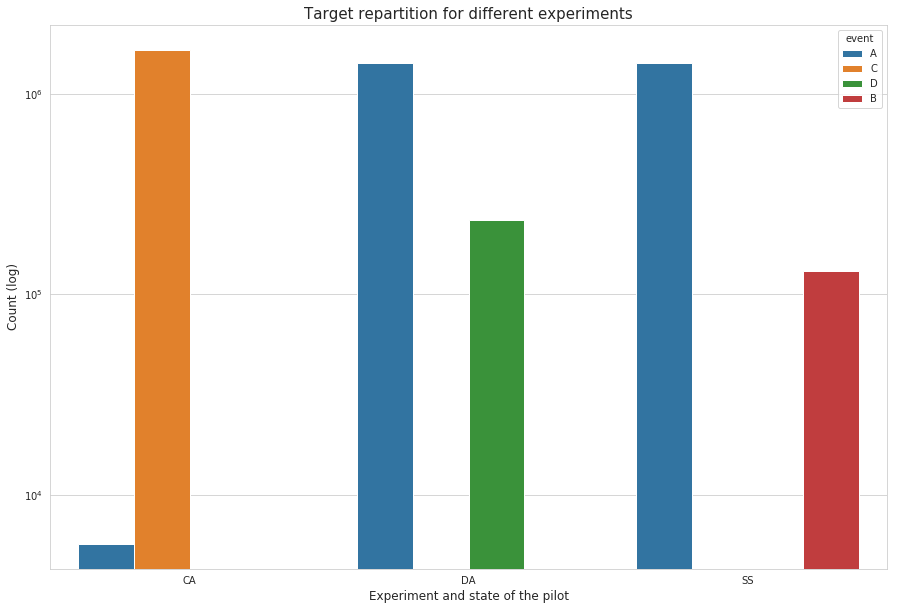

In [8]:
plt.figure(figsize=(15,10))
sns.countplot('experiment', hue='event', data=train_df)
plt.xlabel("Experiment and state of the pilot", fontsize=12)
plt.ylabel("Count (log)", fontsize=12)
plt.yscale('log')
plt.title("Target repartition for different experiments", fontsize=15)
plt.show()

The experiment of the test set is LOFT (Line Oriented Flight Training), which is a full flight (take off, flight, and landing) in a flight simulator. 

### Seat
Which seat the pilot is sitting in.
- 0 : left seat
- 1 : right seat

This probably has nothing to do with the outcome of the experiment though.

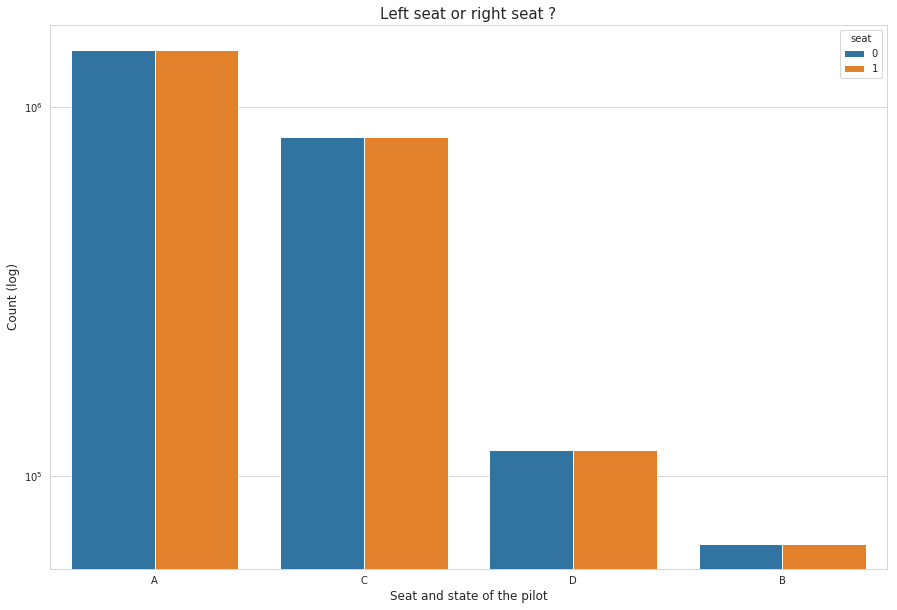

In [9]:
plt.figure(figsize=(15,10))
sns.countplot('event', hue='seat', data=train_df)
plt.xlabel("Seat and state of the pilot", fontsize=12)
plt.ylabel("Count (log)", fontsize=12)
plt.yscale('log')
plt.title("Left seat or right seat ?", fontsize=15)
plt.show()

### Time of the experiment

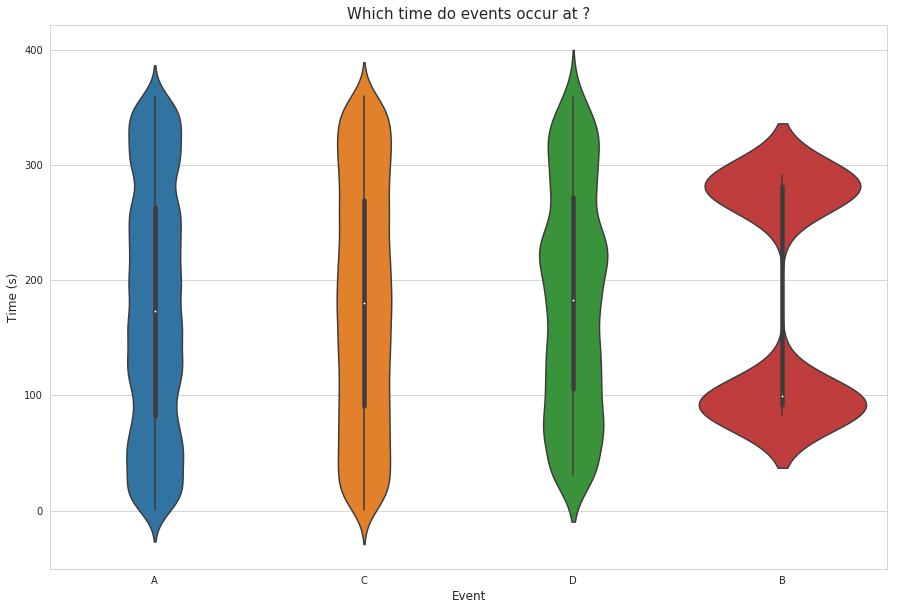

In [10]:
plt.figure(figsize=(15,10))
sns.violinplot(x='event', y='time', data=train_df.sample(50000))
plt.ylabel("Time (s)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("Which time do events occur at ?", fontsize=15)
plt.show()

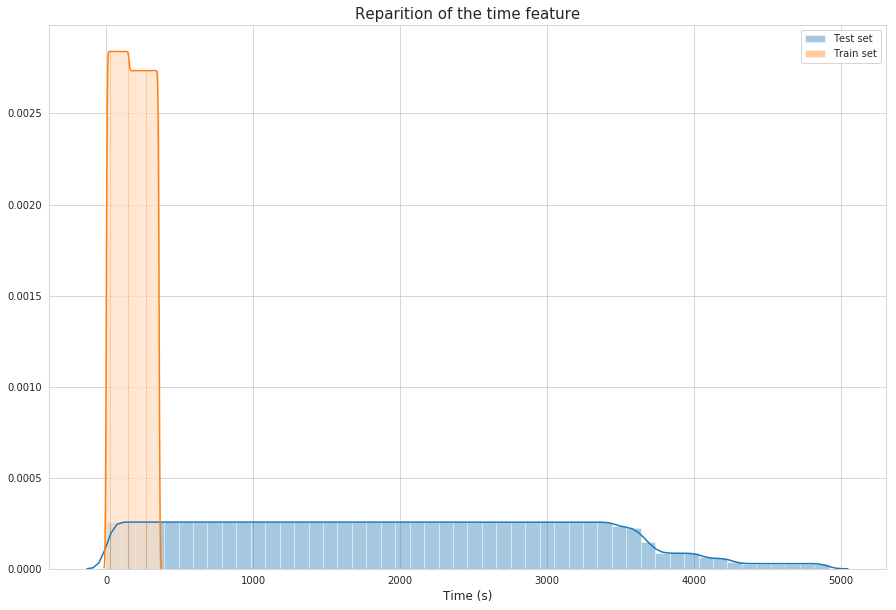

In [11]:
plt.figure(figsize=(15,10))
sns.distplot(test_df['time'], label='Test set')
sns.distplot(train_df['time'], label='Train set')
plt.legend()
plt.xlabel("Time (s)", fontsize=12)
plt.title("Reparition of the time feature", fontsize=15)
plt.show()

The repartition of events is interesting. However, we can't use this feature because time in the flight simulator has nothing to do with time in the experiments. 
It's a shame because take-off and landing could have been exploited.

### Electroencephalogram recordings

In [12]:
eeg_features = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]

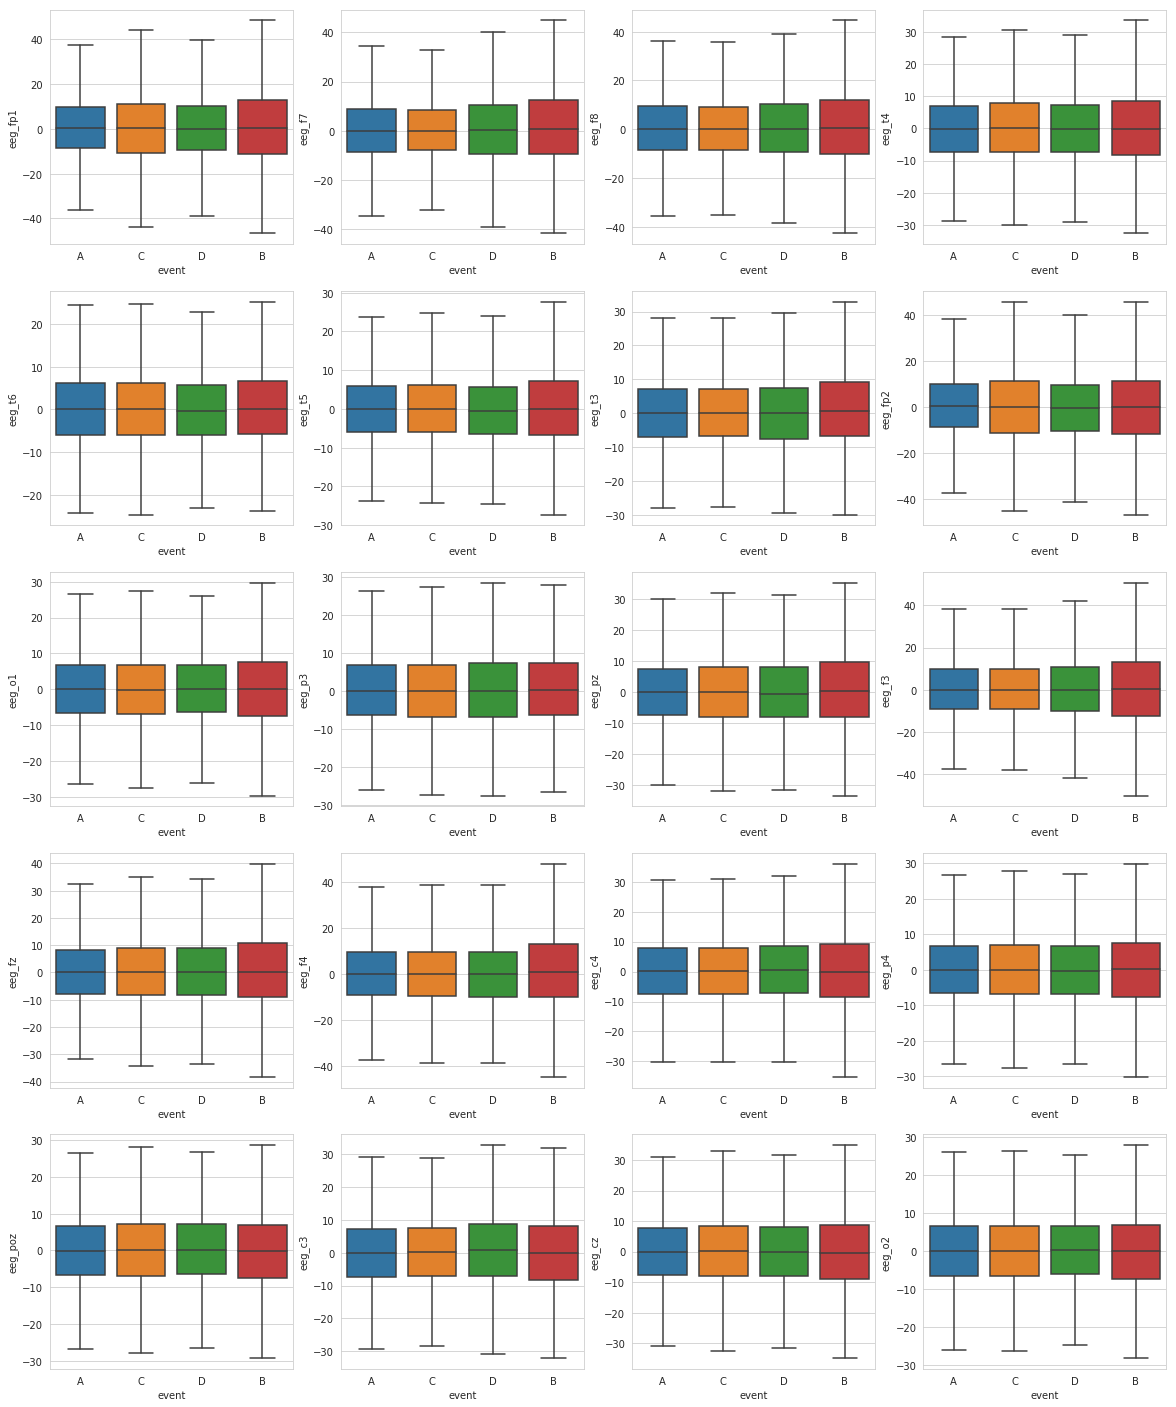

In [13]:
plt.figure(figsize=(20,25))
i = 0

for egg in eeg_features:
    i += 1
    plt.subplot(5, 4, i)
    sns.boxplot(x='event', y=egg, data=train_df.sample(50000), showfliers=False)

plt.show()

We Also check if features have the same distribution on the test and train set

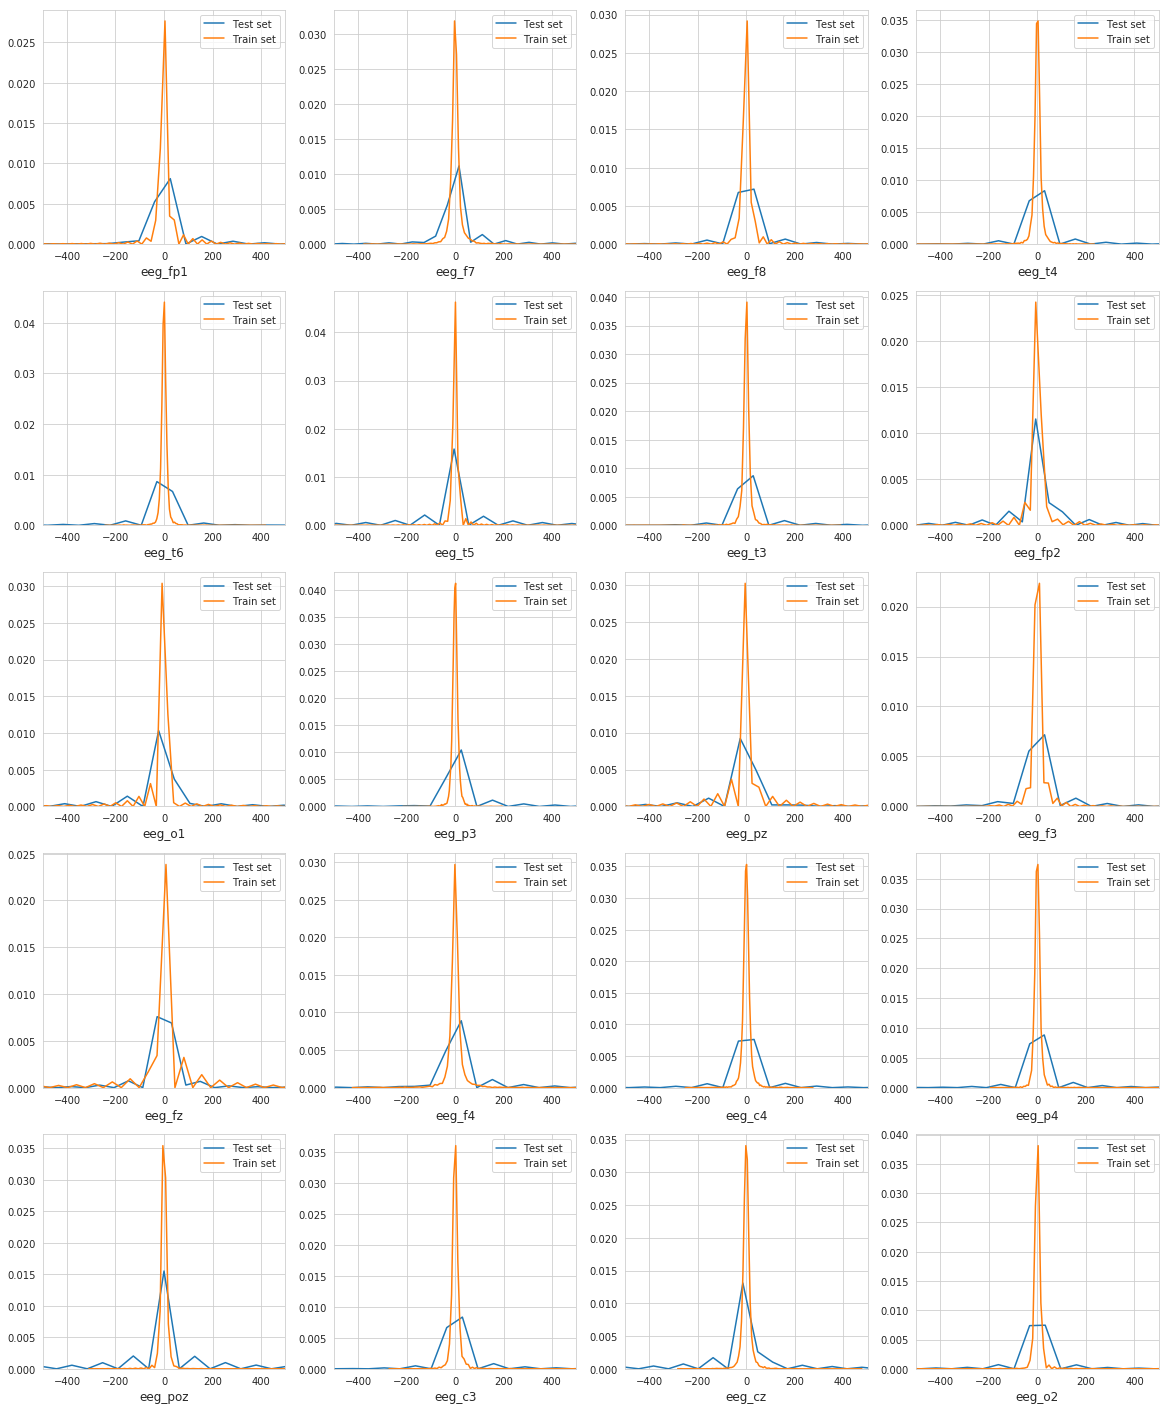

In [14]:
plt.figure(figsize=(20,25))
plt.title('Eeg features distributions')
i = 0

for eeg in eeg_features:
    i += 1
    plt.subplot(5, 4, i)
    sns.distplot(test_df.sample(10000)[eeg], label='Test set', hist=False)
    sns.distplot(train_df.sample(10000)[eeg], label='Train set', hist=False)
    plt.xlim((-500, 500))
    plt.legend()
    plt.xlabel(eeg, fontsize=12)

plt.show()

Reparitions seem consistent :  Gaussians with a sinusoïdal noise centered at 0. Note that the variance is larger on the test set.

### Electrocardiogram
- 3-point Electrocardiogram signal. The sensor had a resolution/bit of .012215 µV and a range of -100mV to +100mV. The data are provided in microvolts.

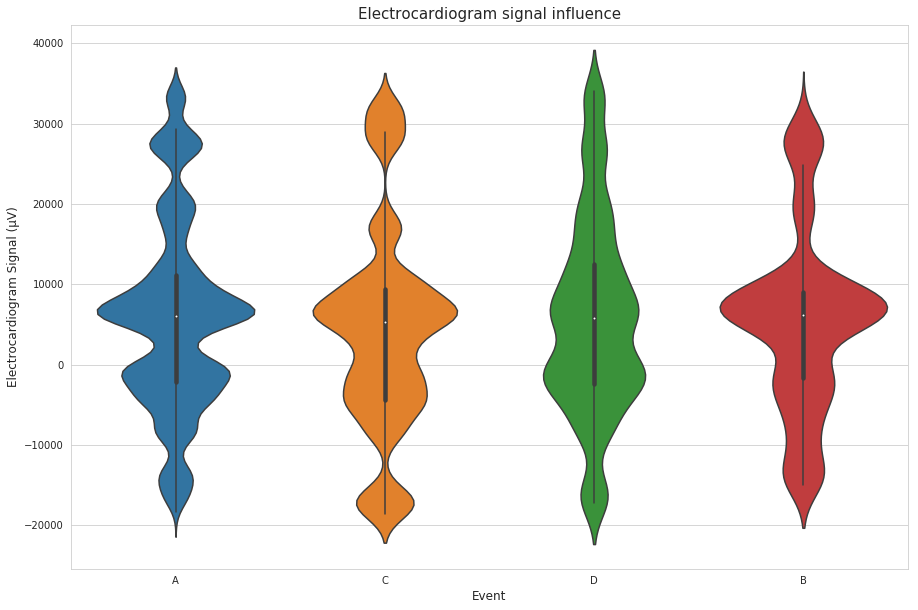

In [15]:
plt.figure(figsize=(15,10))
sns.violinplot(x='event', y='ecg', data=train_df.sample(50000))
plt.ylabel("Electrocardiogram Signal (µV)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("Electrocardiogram signal influence", fontsize=15)
plt.show()

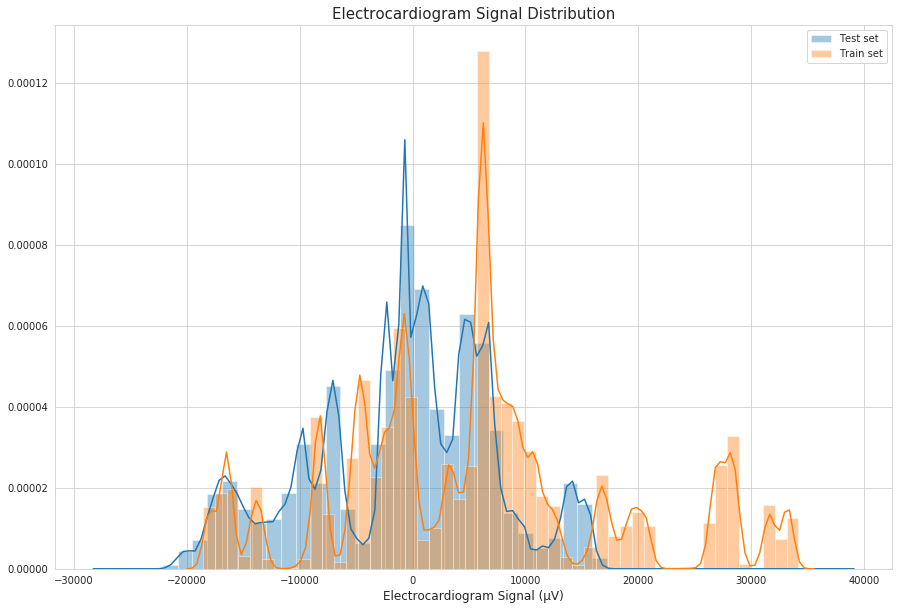

In [16]:
plt.figure(figsize=(15,10))
sns.distplot(test_df['ecg'], label='Test set')
sns.distplot(train_df['ecg'], label='Train set')
plt.legend()
plt.xlabel("Electrocardiogram Signal (µV)", fontsize=12)
plt.title("Electrocardiogram Signal Distribution", fontsize=15)
plt.show()

Except foir the >20000-ish samples, train/test repartitions are similar.

### Respiration 
- A measure of the rise and fall of the chest. The sensor had a resolution/bit of .2384186 µV and a range of -2.0V to +2.0V. The data are provided in microvolts.

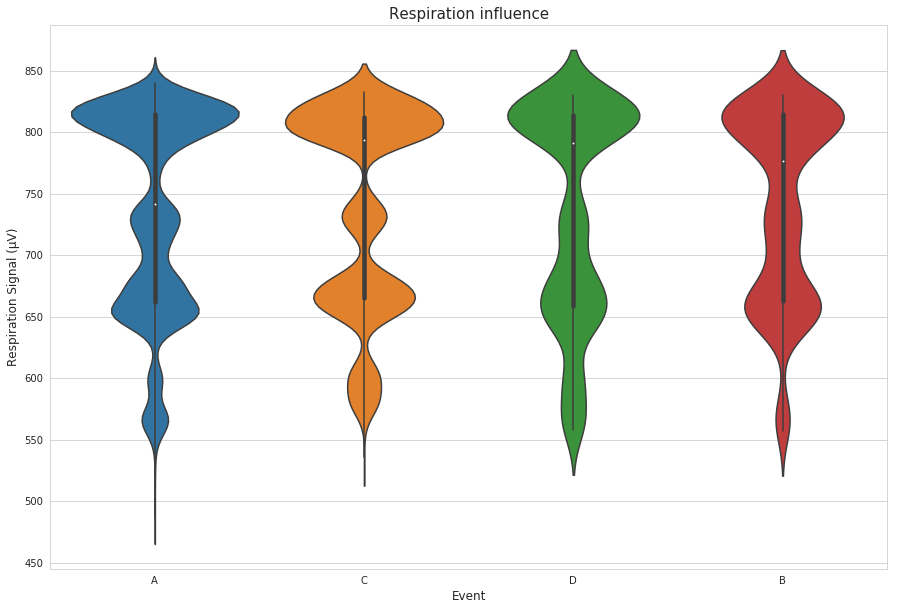

In [17]:
plt.figure(figsize=(15,10))
sns.violinplot(x='event', y='r', data=train_df.sample(50000))
plt.ylabel("Respiration Signal (µV)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("Respiration influence", fontsize=15)
plt.show()

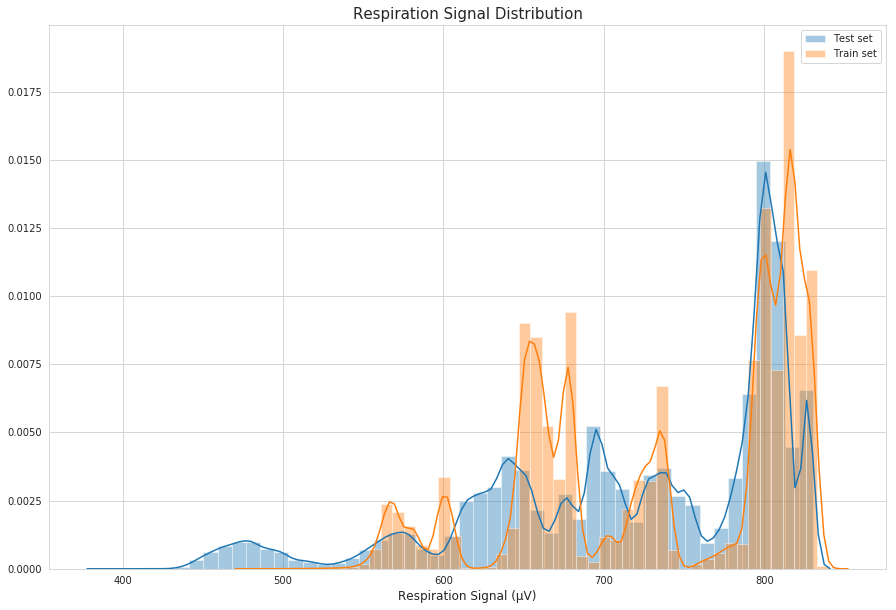

In [18]:
plt.figure(figsize=(15,10))
sns.distplot(test_df['r'], label='Test set')
sns.distplot(train_df['r'], label='Train set')
plt.legend()
plt.xlabel("Respiration Signal (µV)", fontsize=12)
plt.title("Respiration Signal Distribution", fontsize=15)
plt.show()

Nothing much to say here, the test set has a bunch of sample with lower values though.

### Galvanic Skin Response
 - A measure of electrodermal activity. The sensor had a resolution/bit of .2384186 µV and a range of -2.0V to +2.0V. The data are provided in microvolts.
 > "The galvanic skin response (GSR, which falls under the umbrella term of electrodermal activity, or EDA) refers to changes in sweat gland activity that are reflective of the intensity of our emotional state, otherwise known as emotional arousal."

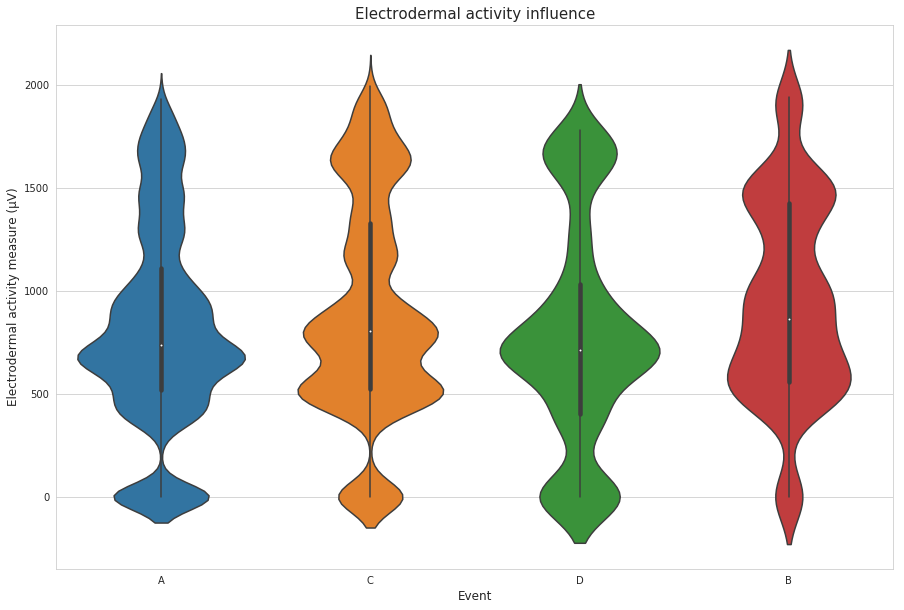

In [19]:
plt.figure(figsize=(15,10))
sns.violinplot(x='event', y='gsr', data=train_df.sample(50000))
plt.ylabel("Electrodermal activity measure (µV)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("Electrodermal activity influence", fontsize=15)
plt.show()

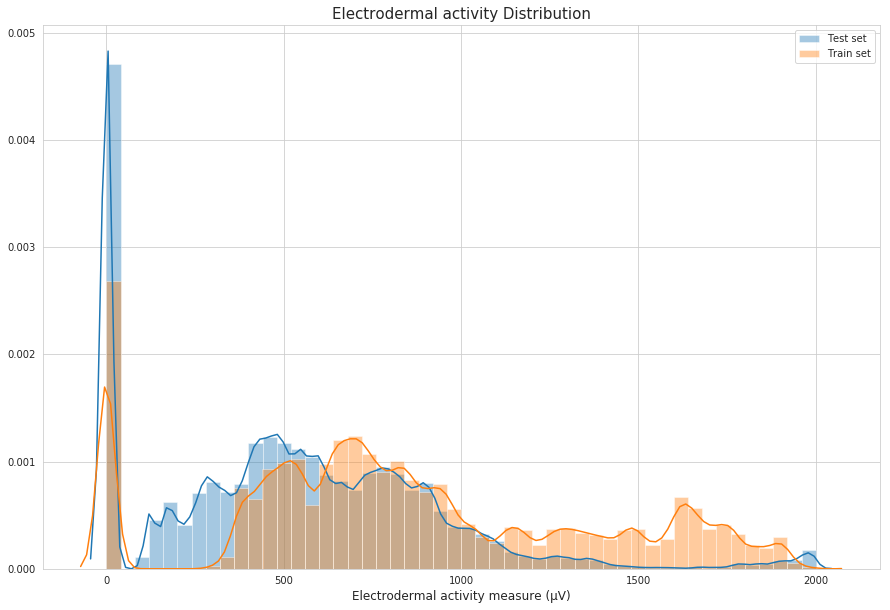

In [20]:
plt.figure(figsize=(15,10))
sns.distplot(test_df['gsr'], label='Test set')
sns.distplot(train_df['gsr'], label='Train set')
plt.legend()
plt.xlabel("Electrodermal activity measure (µV)", fontsize=12)
plt.title("Electrodermal activity Distribution", fontsize=15)
plt.show()

# Feature Engineering (will work on that later)

# Choosing a Model

We're dealing with a multi-class classification problem, we've decided to use boosting of decision trees. More specifically, LightGBM library.<br>

We're using some basic parameters, using mainly num_leaves and min_child_weight to avoid overfitting, but also subsample and colsample.

### Normalizing 

Because of earlier remarks, we normalize our features. 

I do believe the following features depend a lot of the person, therefore I apply a Min/Max Scaler for each pilot.

In [21]:
features_n = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2", "ecg", "r", "gsr"]

In [22]:
train_df['pilot'] = 100 * train_df['seat'] + train_df['crew']
test_df['pilot'] = 100 * test_df['seat'] + test_df['crew']

print("Number of pilots : ", len(train_df['pilot'].unique()))

Number of pilots :  18


In [23]:
def normalize_by_pilots(df):
    pilots = df["pilot"].unique()
    for pilot in tqdm(pilots):
        ids = df[df["pilot"] == pilot].index
        scaler = MinMaxScaler()
        df.loc[ids, features_n] = scaler.fit_transform(df.loc[ids, features_n])
        
    return df

In [24]:
train_df = normalize_by_pilots(train_df)
test_df = normalize_by_pilots(test_df)

### Train / Test split

In [25]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=420)
print(f"Training on {train_df.shape[0]} samples.")

Training on 3893936 samples.


### Model
Note that I did not bother tweaking the parameters yet. For optimization, we need to do the hyperparameters tuning

In [26]:
features = ["crew", "seat"] + features_n
      
def run_lgb(df_train, df_test):
    # Classes as integers
    dic = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    try:
        df_train["event"] = df_train["event"].apply(lambda x: dic[x])
        df_test["event"] = df_test["event"].apply(lambda x: dic[x])
    except: 
        pass
    
    params = {"objective" : "multiclass",
              "num_class": 4,
              "metric" : "multi_error",
              "num_leaves" : 30,
              "min_child_weight" : 50,
              "learning_rate" : 0.1,
              "bagging_fraction" : 0.7,
              "feature_fraction" : 0.7,
              "bagging_seed" : 420,
              "verbosity" : -1
             }
    
    
    
    
    lg_train = lgb.Dataset(df_train[features], label=(df_train["event"]))
    lg_test = lgb.Dataset(df_test[features], label=(df_test["event"]))
    model = lgb.train(params, lg_train, 1000, valid_sets=[lg_test], early_stopping_rounds=50, verbose_eval=100)
    
    return model

In [27]:
model = run_lgb(train_df, val_df)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_error: 0.0821512
[200]	valid_0's multi_error: 0.068337
[300]	valid_0's multi_error: 0.0598006
[400]	valid_0's multi_error: 0.0539228
[500]	valid_0's multi_error: 0.0499443
[600]	valid_0's multi_error: 0.0467958
[700]	valid_0's multi_error: 0.044165
[800]	valid_0's multi_error: 0.0419852
[900]	valid_0's multi_error: 0.0399277
[1000]	valid_0's multi_error: 0.0383067
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_error: 0.0383067


### Feature importance

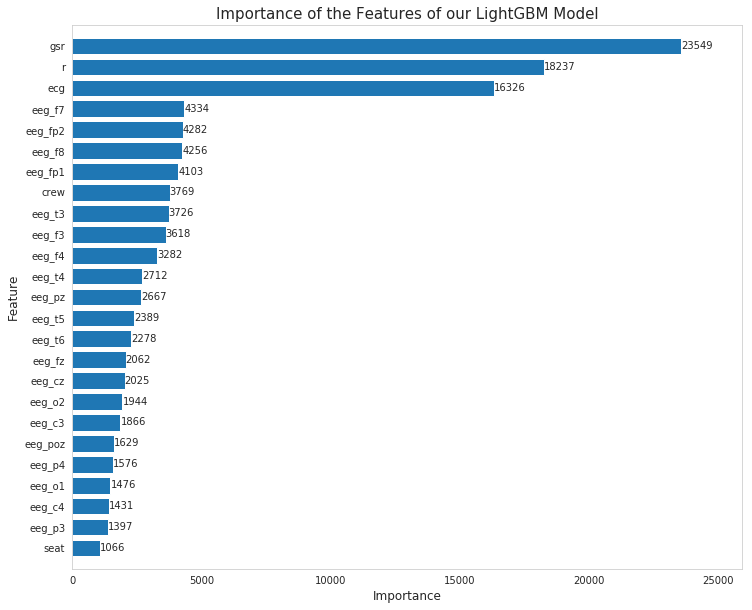

In [28]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, height=0.8, ax=ax)
ax.grid(False)
plt.ylabel('Feature', size=12)
plt.xlabel('Importance', size=12)
plt.title("Importance of the Features of our LightGBM Model", fontsize=15)
plt.show()

### Confusion Matrix

In [29]:
pred_val = model.predict(val_df[features], num_iteration=model.best_iteration)
#pred_train = model.predict(train_df[features], num_iteration=model.best_iteration)

In [30]:
print("Log loss on validation data :", round(log_loss(np.array(val_df["event"].values), pred_val), 3))

Log loss on validation data : 0.108


In [31]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f' if normalize else 'd'

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = (cm.max()+cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

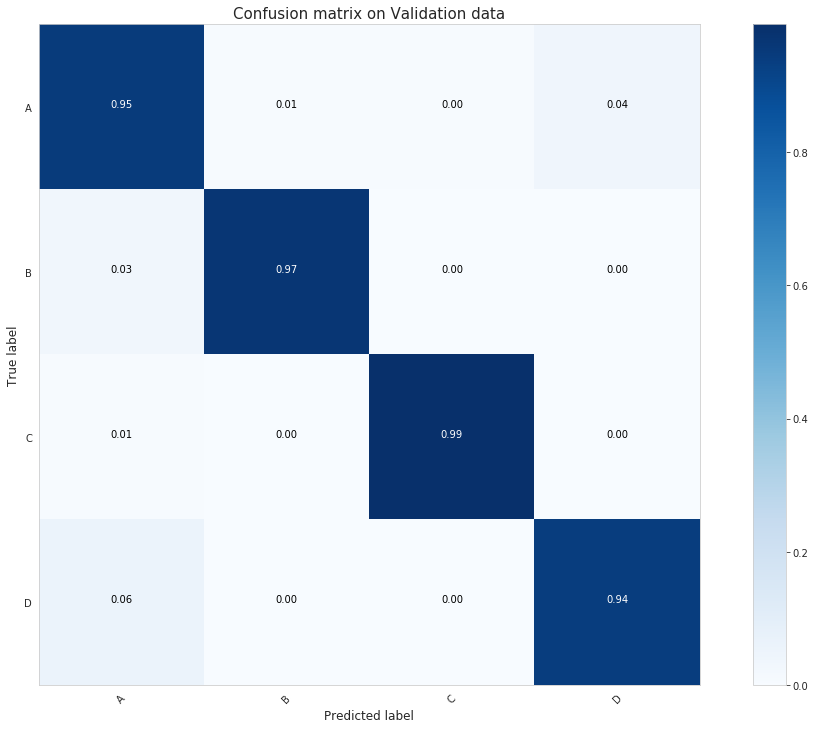

In [32]:
conf_mat_val = confusion_matrix(np.argmax(pred_val, axis=1), val_df["event"].values)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)

### Submission

In [33]:
pred_test = model.predict(test_df[features], num_iteration=model.best_iteration)

In [34]:
submission = pd.DataFrame(np.concatenate((np.arange(len(test_df))[:, np.newaxis], pred_test), axis=1), columns=['id', 'A', 'B', 'C', 'D'])
submission['id'] = submission['id'].astype(int)

In [35]:
submission.head()

,id,A,B,C,D
0,0,0.983302,0.007937,0.002576,0.006186
1,1,0.988025,0.000176,0.000929,0.010870
2,2,0.979629,0.006281,0.004426,0.009664
3,3,0.988181,0.000185,0.000976,0.010658
4,4,0.984778,0.005659,0.004741,0.004822


In [36]:
submission.to_csv("submission.csv", index=False)